In [198]:
import os 
import glob
import pvlib
from bs4 import BeautifulSoup as bs
import re
import requests
import shutil
import pandas as pd
import proplot as pplt
from epw import epw
import sys
from tzwhere import tzwhere
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.utilities import utils

# download

In [26]:
tmy2_files = glob.glob(os.path.join("/Users/jmccarty/Nextcloud/Projects/13_CISBAT23_idf/tmy2","*.epw"))

In [38]:
wmo_code_dict = {}

for fname in tmy2_files:
    with open(fname, "r") as fp:
        cz = fname.split(os.sep)[-1].split("_")[0]
        tmy2 = fp.readline()
        wmo_code = tmy2.split(",")[5]
        wmo_code_dict.update({wmo_code:cz})

In [39]:
tmy_3_files = []

for dir in glob.glob(os.path.join("/Users/jmccarty/Nextcloud/Projects/13_CISBAT23_idf/tmy3_init","*")):
    tmy_3_files.append(glob.glob(os.path.join(dir,"*.epw")))
    
tmy_3_files = [item for sublist in tmy_3_files for item in sublist]


In [55]:
for fname in tmy_3_files:
    fname_elements = fname.split(os.sep)[-1].split(".")
    city = ("_").join(fname_elements[0:2])
    print(city)
    wmo_code = fname_elements[-2].split("_")[0]
    cz = wmo_code_dict[str(wmo_code)]
    dst = os.path.join("/Users/jmccarty/Nextcloud/Projects/13_CISBAT23_idf/tmy3",f"{cz.lower()}_{city}.epw")
    shutil.copy(fname,dst)

USA_CA_San_Francisco
USA_MD_Baltimore-Washington_Intl
USA_CA_Los_Angeles
USA_NV_Las_Vegas-McCarran
USA_MN_Minneapolis-St_Paul
USA_TX_Houston-Bush_Intercontinental
USA_IL_Chicago_OHare
USA_AZ_Phoenix-Sky_Harbor
USA_MT_Helena_Rgnl
USA_NM_Albuquerque_Intl
USA_FL_Miami_Intl
USA_CO_Boulder-Table_Mountain
USA_GA_Atlanta-Hartsfield-Jackson_Intl
USA_MN_Duluth_Intl
USA_AK_Fairbanks_Intl
USA_WA_Seattle-Tacoma_Intl


# clean dni

In [176]:

def calc_irrad_profile(location_dict, df):
    solarpos = pvlib.solarposition.get_solarposition(
        df.index.shift(freq="-30T"), latitude=location_dict['lat'],
        longitude=location_dict['lon'], altitude=location_dict['elevation'],
        pressure=df['atmos_Pa'],  # convert from millibar to Pa
        temperature=df['drybulb_C'])
    solarpos.index = df.index  # reset index to end of the hour

    out_disc = pvlib.irradiance.disc(df['glohorrad_Whm2'], 
                                     solarpos.zenith, 
                                     df.index, 
                                     df['atmos_Pa'])
    df_complete = pvlib.irradiance.complete_irradiance(solar_zenith=solarpos.apparent_zenith,
                                                   ghi=df['glohorrad_Whm2'],
                                                   dni=out_disc.dni,
                                                   dhi=None#df['difhorrad_Whm2']
                                                   )
    out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
    out_disc['dhi_disc'] = df_complete.dhi

    return df_complete, out_disc


def out_epw(epw_object,file_path):
    epw_object.write(file_path)


In [177]:
tmy3_epw_files = glob.glob(os.path.join("/Users/jmccarty/GitHub/cmip6_and_buildings/weather_files/tmy3","*.epw"))

for fname in tmy3_epw_files:
    base_epw = epw()
    base_epw.read(fname)
    location = utils.tmy_location(fname)
    epw_df = utils.tmy_to_dataframe(fname)
    tz = tzwhere.tzwhere(forceTZ=True)
    timezone = tz.tzNameAt(location['lat'], location['lon'], forceTZ=True)
    if location['utc']<0:
        epw_df.index = epw_df.index.tz_localize("UTC").tz_convert(timezone) + pd.Timedelta(hours=abs(location['utc']))
    else:
        epw_df.index = epw_df.index.tz_localize("UTC").tz_convert(timezone) - pd.Timedelta(hours=location['utc'])
    new_solar, disc = calc_irrad_profile(location, epw_df)
    base_epw_df = base_epw.dataframe
    base_epw_df['Direct Normal Radiation'] = new_solar['dni'].fillna(0).values
    base_epw_df['Diffuse Horizontal Radiation'] = new_solar['dhi'].fillna(0).values
    base_epw_df['Global Horizontal Radiation'] = new_solar['ghi'].fillna(0).values

    dst_name = fname.replace('tmy3','tmy3_corrected')
    out_epw(base_epw, dst_name)

# Compare

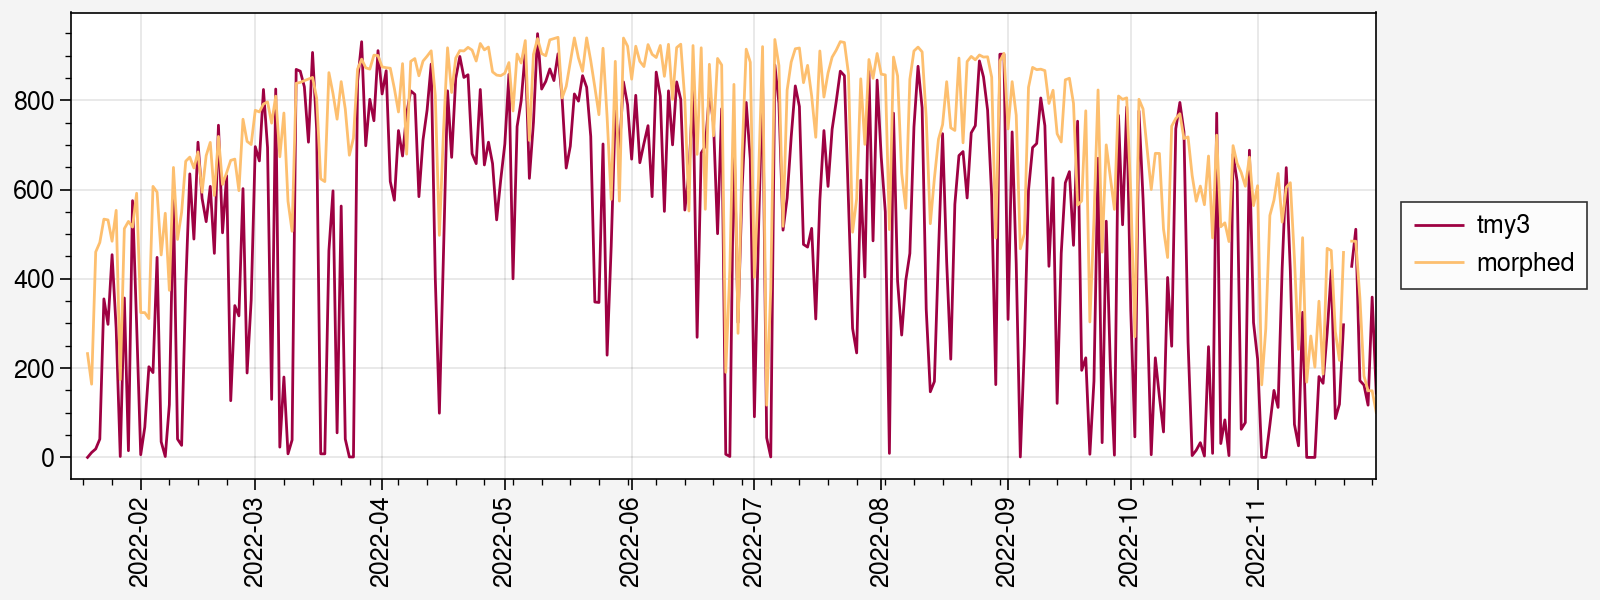

In [240]:
cz = '3b'

baseline = f"/Users/jmccarty/GitHub/cmip6_and_buildings/weather_files/morphed/{cz}/historical/EPWs/baseline.epw"
tmy3 = f"/Users/jmccarty/GitHub/cmip6_and_buildings/weather_files/tmy3/{cz}.epw"
morphed = f"/Users/jmccarty/GitHub/cmip6_and_buildings/weather_files/morphed/{cz}/ssp245/EPWs/ssp245_50_2065-2095.epw"

baseline = utils.tmy_to_dataframe(baseline)['dirnorrad_Whm2'].rename('modified').reset_index(drop=True)
tmy3 = utils.tmy_to_dataframe(tmy3)['dirnorrad_Whm2'].rename('tmy3').reset_index(drop=True)
morphed = utils.tmy_to_dataframe(morphed)['dirnorrad_Whm2'].rename('morphed').reset_index(drop=True)

df = pd.concat([baseline,tmy3,morphed],axis=1)
df.set_index(utils.ts_8760(),inplace=True)
fig, axe = pplt.subplots(figsize=(8,3))

axe[0].line(df[df['morphed']>0].resample('D').max(), lw=1, cycle=pplt.Cycle('spectral',4))

fig.legend(loc='right',ncols=1)